In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabel-videogame-dataset/summary-data.csv
/kaggle/input/multilabel-videogame-dataset/genre-tag-data.csv


## 📌 Data and Library Set-Up
Import crucial libraries and datapaths in Kaggle.

In [104]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader 
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split

from ast import literal_eval
import matplotlib.pyplot as plt

In [105]:
summary_datapath = '/kaggle/input/multilabel-videogame-dataset/summary-data.csv'
genretag_datapath = '/kaggle/input/multilabel-videogame-dataset/genre-tag-data.csv'

## 📌 Load Data in the Kaggle Notebook
Load data + little preprocessing for the training and testing procedures. Most of the preprocessing in the data are already done in a separate notebok.

In [106]:
summary_df = pd.read_csv(summary_datapath)
summary_df.head()

,id,clean_summary
0,1,the ultimate thief is back! tread softly as yo...
1,2,thief is a first-person stealth game that like...
2,3,"in the third instalment of the thief series, m..."
3,4,there is a rising tide of fear in the city. ha...
4,5,baldur gate is a fantasy role-playing video ga...


In [107]:
genretag_df = pd.read_csv(genretag_datapath)
genretag_df.head()

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,1,"['adventure', 'action', 'simulation']",1,1,0,0,0,0,0,0,1,0
1,2,"['adventure', 'simulation']",0,1,0,0,0,0,0,0,1,0
2,3,"['adventure', 'action', 'simulation']",1,1,0,0,0,0,0,0,1,0
3,4,"['adventure', 'action']",1,1,0,0,0,0,0,0,0,0
4,5,['rpg'],0,0,0,0,0,0,0,1,0,0


In [108]:
genretag_df['compiled_genrelist'] = genretag_df.iloc[:, 2:].values.tolist()
genretag_df.head()

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy,compiled_genrelist
0,1,"['adventure', 'action', 'simulation']",1,1,0,0,0,0,0,0,1,0,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0]"
1,2,"['adventure', 'simulation']",0,1,0,0,0,0,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]"
2,3,"['adventure', 'action', 'simulation']",1,1,0,0,0,0,0,0,1,0,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0]"
3,4,"['adventure', 'action']",1,1,0,0,0,0,0,0,0,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,5,['rpg'],0,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [109]:
genretag_df['new_genrelist'] = genretag_df['new_genrelist'].apply(literal_eval)

In [110]:
print(summary_df.shape)
print(genretag_df.shape)

(145763, 2)
(145763, 13)


## 📌 Splitting the Data to Train, Test, and Validation Sets
Split: Training Set (80%), Testing Set (10%), Validation Set (10%)|

In [111]:
X_train, X_test, y_train, y_test = train_test_split(summary_df, genretag_df, train_size=0.8, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=0)

In [112]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}\n')

X_train shape: (116610, 2)
y_train shape: (116610, 13)

X_test shape: (14576, 2)
y_test shape: (14576, 13)

X_val shape: (14577, 2)
y_val shape: (14577, 13)



In [113]:
X_train

,id,clean_summary
121393,192571,explore procedurally generated living worlds i...
72408,119238,"you recently joined the teen titans, but you d..."
89482,145718,a historical strategy sim set in a beautiful a...
4371,4795,"known as dawn of discovery in north america, a..."
64302,107440,click and manage tycoon is a clicker and manag...
...,...,...
41993,55158,disney magical dice allows players to play in ...
97639,156078,the famous adelaide street circuit is now avai...
95939,153772,"someone has ordered a package, but no one know..."
117952,188468,its a puzzle-game where you need to collect di...


## 📌 EDA for Train, Test, and Validation Sets
Check whether our train, test, and valid sets are okay for the following steps.

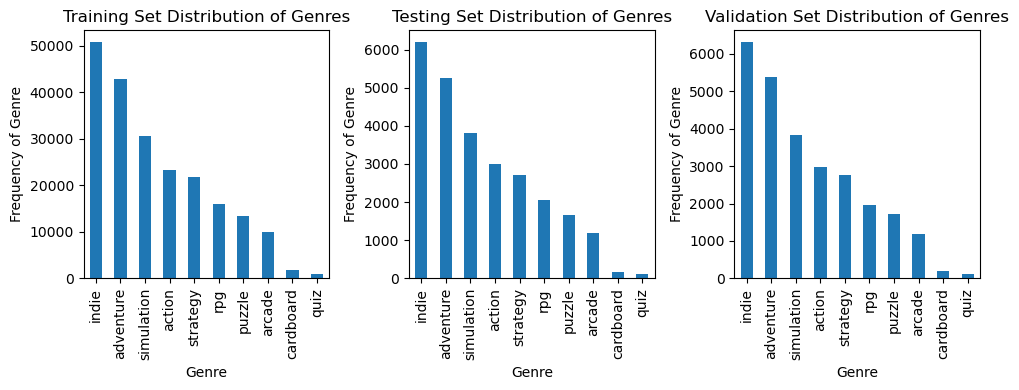

In [114]:
def genre_counter(df):
    genre_count = df['new_genrelist'].explode('new_genrelist').reset_index(drop=True)
    return genre_count.value_counts()
    
training_valuecount = genre_counter(y_train)
testing_valuecount = genre_counter(y_test)
validation_valuecount = genre_counter(y_val)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
training_valuecount.plot(kind='bar', title='Training Set Distribution of Genres', xlabel='Genre', ylabel='Frequency of Genre', ax=ax1)
testing_valuecount.plot(kind='bar', title='Testing Set Distribution of Genres', xlabel='Genre', ylabel='Frequency of Genre', ax=ax2)
validation_valuecount.plot(kind='bar', title='Validation Set Distribution of Genres', xlabel='Genre', ylabel='Frequency of Genre', ax=ax3)
plt.tight_layout()

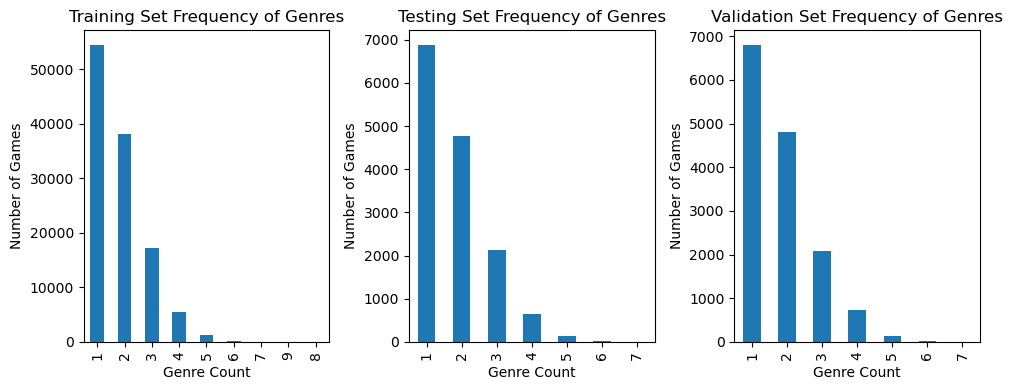

In [115]:
def freq_counter(df):
    freq_count = df['new_genrelist'].apply(len)
    return freq_count.value_counts()

training_freqcount = freq_counter(y_train)
testing_freqcount = freq_counter(y_test)
validation_freqcount = freq_counter(y_val)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
training_freqcount.plot(kind='bar', title='Training Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax1)
testing_freqcount.plot(kind='bar', title='Testing Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax2)
validation_freqcount.plot(kind='bar', title='Validation Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax3)
plt.tight_layout()

## 📌 Model Development
We shall use and finetune a pretrained DistilBERT, a distilled version of BERT but retains 97% of language understanding abilities, and 60% faster! DistilBERT is a compact, faster, and lighter model that is cheaper to pre-train and can easily be used for on-device applications.

### 📝 Set-up device for GPU usage
Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU.

In [116]:
from torch import cuda
device = torch.device('cuda' if cuda.is_available() else 'cpu')

print(f"Current device: {device}")

Current device: cuda


### 📝 Initializing Training Parameters

In [117]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 1e-05
NUM_WORKERS = 2

### 📝 Preparing the Dataset and Dataloader

In [118]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len: int, eval_mode: bool = False):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.text = self.data.clean_summary
        self.eval_mode = eval_mode 
        if self.eval_mode is False:
            self.targets = self.data.compiled_genrelist
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }
                
        if self.eval_mode is False:
            output['targets'] = torch.tensor(self.targets.iloc[index], dtype=torch.float)
                
        return output

### 📝 Loading Tokenizer and Generating Training Set

In [119]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

merged_trainset = pd.merge(X_train, y_train, on='id')[['clean_summary', 'compiled_genrelist']]
training_set = MultiLabelDataset(merged_trainset, tokenizer, MAX_LEN)

#### Verify generated training set at index[0]:

In [120]:
training_set[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2352: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'ids': tensor([  101,  8849, 24508,  2135,  7013,  2542,  8484,  1999,  2023,  5472,
          8758, 22531,  1012,  3113,  5606,  1997,  3494,  1999,  3655,  1010,
          3143,  8795,  2015,  1010,  7477,  3928,  5167,  1010,  4965,  1998,
          6519, 24014,  2115,  2188,  2030,  2954,  9219,  1999, 20264,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

### 📝 Create DataLoader

In [121]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }
training_loader = DataLoader(training_set, **train_params)

## 📌 Neural Network for Finetuning

In [122]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 10) # 10 for 10 labels

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [123]:
model = DistilBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

## 📌 Loss Function and Optimizer

In [124]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [125]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

## 📌 Finetuning
This part serves as the "training" of the model. Since we are using a pre-trained BERT model, we are just finetuning the model to make it appropriate in our video game dataset.

In [126]:
def train(epoch):
    
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%1000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

In [127]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Epoch: 0, Loss:  0.6777003407478333


1000it [07:06,  2.36it/s]

Epoch: 0, Loss:  0.25092050433158875


2000it [14:11,  2.35it/s]

Epoch: 0, Loss:  0.24613232910633087


3000it [21:16,  2.35it/s]

Epoch: 0, Loss:  0.2656770646572113


4000it [28:21,  2.37it/s]

Epoch: 0, Loss:  0.2787495255470276


5000it [35:26,  2.36it/s]

Epoch: 0, Loss:  0.24420006573200226


6000it [42:30,  2.36it/s]

Epoch: 0, Loss:  0.3357737958431244


7000it [49:35,  2.36it/s]

Epoch: 0, Loss:  0.1964551955461502


7289it [51:37,  2.35it/s]


## 📌 Generate Probabilities
This serves as the testing for our model, where we generate probabilities for the training dataset.

In [132]:
test_data = X_test.copy()
test_data

,id,clean_summary
141415,226372,rerun is a turn-based tactical rougelike where...
20791,26491,you play a character living peacefully in his ...
112669,176024,mr. monopoly is your master of ceremonies as t...
117176,186954,draw lines on the screen to send love and kiss...
11510,12910,sorceress magica de spell and her rotten raven...
...,...,...
88980,144944,headcount is an action-packed bullet-hell vr s...
117510,187489,"the game has motion control, so you have to us..."
89519,145773,you are isabella song a hacker pi. your job is...
140469,224967,an interesting and novel adventure trip compos...


In [133]:
test_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN, eval_mode = True)
testing_params = {'batch_size': TRAIN_BATCH_SIZE,
               'shuffle': False,
               'num_workers': 2
                }
test_loader = DataLoader(test_set, **testing_params)

In [134]:
all_test_pred = []

def test(epoch):
    model.eval()
    
    with torch.inference_mode():
    
        for _, data in tqdm(enumerate(test_loader, 0)):


            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids)
            probas = torch.sigmoid(outputs)

            all_test_pred.append(probas)
    return probas

In [135]:
probas = test(model)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2352: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2352: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to th

In [136]:
all_test_pred = torch.cat(all_test_pred)

In [137]:
submit_df = test_data.copy()
submit_df.drop("clean_summary", inplace=True, axis=1)

In [138]:
label_columns = ["action","adventure","arcade","cardboard","indie","puzzle","quiz","rpg","simulation","strategy"]

In [139]:
for i,name in enumerate(label_columns):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [142]:
submit_df.to_csv('submission.csv', index=False)
submit_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
141415,226372,0.023506,0.182517,0.011573,0.024602,0.627480,0.012709,0.003397,0.232784,0.157846,0.970524
20791,26491,0.049560,0.803143,0.012203,0.006722,0.707965,0.253399,0.003549,0.062434,0.052682,0.063925
112669,176024,0.021852,0.042697,0.055567,0.588657,0.066987,0.178423,0.329249,0.019667,0.217484,0.441967
117176,186954,0.309030,0.197611,0.303371,0.006463,0.314224,0.454977,0.004140,0.013682,0.095701,0.101600
11510,12910,0.712473,0.491250,0.136675,0.002553,0.050433,0.104715,0.003223,0.014220,0.040703,0.034337
...,...,...,...,...,...,...,...,...,...,...,...
88980,144944,0.682589,0.203857,0.078100,0.001089,0.693518,0.005313,0.000398,0.039048,0.101482,0.029517
117510,187489,0.101889,0.086000,0.094143,0.031011,0.114606,0.946910,0.034873,0.006649,0.044610,0.149466
89519,145773,0.048242,0.666634,0.017855,0.003338,0.624768,0.091255,0.001878,0.052581,0.342530,0.098250
140469,224967,0.015854,0.862071,0.007162,0.002896,0.545159,0.040757,0.001300,0.046601,0.208899,0.039029


In [143]:
y_test

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy,compiled_genrelist
141415,226372,"[indie, rpg, strategy]",0,0,0,0,1,0,0,1,0,1,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 1]"
20791,26491,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
112669,176024,[cardboard],0,0,0,1,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
117176,186954,"[action, arcade, puzzle]",1,0,1,0,0,1,0,0,0,0,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
11510,12910,[action],1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88980,144944,"[adventure, action, indie, simulation]",1,1,0,0,1,0,0,0,1,0,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0]"
117510,187489,"[arcade, puzzle]",0,0,1,0,0,1,0,0,0,0,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
89519,145773,"[adventure, indie, simulation]",0,1,0,0,1,0,0,0,1,0,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]"
140469,224967,[strategy],0,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


## 📌 Evaluation

In [144]:
!pip install -q torchmetrics watermark

In [145]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
import string
import torchmetrics

from transformers import pipeline
from tqdm.notebook import tqdm
tqdm.pandas()

In [146]:
%load_ext watermark

In [147]:
%watermark --iversions

numpy       : 1.21.6
torchmetrics: 0.11.4
matplotlib  : 3.5.3
sklearn     : 1.0.2
transformers: 4.27.4
torch       : 1.13.0
pandas      : 1.3.5



In [156]:
actual_df = y_test[label_columns].copy()
actual_df

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
141415,0,0,0,0,1,0,0,1,0,1
20791,0,1,0,0,1,0,0,0,0,0
112669,0,0,0,1,0,0,0,0,0,0
117176,1,0,1,0,0,1,0,0,0,0
11510,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
88980,1,1,0,0,1,0,0,0,1,0
117510,0,0,1,0,0,1,0,0,0,0
89519,0,1,0,0,1,0,0,0,1,0
140469,0,0,0,0,0,0,0,0,0,1


In [157]:
score_df = submit_df[label_columns].copy()
score_df

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
141415,0.023506,0.182517,0.011573,0.024602,0.627480,0.012709,0.003397,0.232784,0.157846,0.970524
20791,0.049560,0.803143,0.012203,0.006722,0.707965,0.253399,0.003549,0.062434,0.052682,0.063925
112669,0.021852,0.042697,0.055567,0.588657,0.066987,0.178423,0.329249,0.019667,0.217484,0.441967
117176,0.309030,0.197611,0.303371,0.006463,0.314224,0.454977,0.004140,0.013682,0.095701,0.101600
11510,0.712473,0.491250,0.136675,0.002553,0.050433,0.104715,0.003223,0.014220,0.040703,0.034337
...,...,...,...,...,...,...,...,...,...,...
88980,0.682589,0.203857,0.078100,0.001089,0.693518,0.005313,0.000398,0.039048,0.101482,0.029517
117510,0.101889,0.086000,0.094143,0.031011,0.114606,0.946910,0.034873,0.006649,0.044610,0.149466
89519,0.048242,0.666634,0.017855,0.003338,0.624768,0.091255,0.001878,0.052581,0.342530,0.098250
140469,0.015854,0.862071,0.007162,0.002896,0.545159,0.040757,0.001300,0.046601,0.208899,0.039029


Score for each categories:

In [158]:
for cat in label_columns:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], score_df[cat])}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(score_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.9004976577030974
torchmetrics score: 0.9004976749420166
##############################

Category: adventure
Sklearn score: 0.8612046025758335
torchmetrics score: 0.8612046241760254
##############################

Category: arcade
Sklearn score: 0.8465519469806682
torchmetrics score: 0.8465518951416016
##############################

Category: cardboard
Sklearn score: 0.9243014791380201
torchmetrics score: 0.9243015050888062
##############################

Category: indie
Sklearn score: 0.863254008668307
torchmetrics score: 0.8632540106773376
##############################

Category: puzzle
Sklearn score: 0.8932235815222572
torchmetrics score: 0.8932235836982727
##############################

Category: quiz
Sklearn score: 0.93603836551689
torchmetrics score: 0.9360383749008179
##############################

Category: rpg
Sklearn score: 0.9064256318904669
torchmetrics score: 0.9064255952835083
##############################

Category: simulation
Sklear

Mean column-wise ROC AUC score on all categories

In [159]:
print(f"Sklearn score: {metrics.roc_auc_score(actual_df[label_columns].values, score_df[label_columns].values, average='macro')}")

Sklearn score: 0.8900107948290839


In [160]:
print(F"torchmetrics score: {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(score_df[label_columns].values),torch.tensor(actual_df[label_columns].values),num_labels=10,thresholds=None )}")

torchmetrics score: 0.8900108337402344


Note to self:

# UWU
Model is still improvable. Find more BERT-based models that could improve results. Also find a more robust evaluation metric that could easily be analyzed and interpreted. Find also models, examples, or anything that addresses data imbalance.